In [1]:
import numpy as np 
import pandas as pd 
import torch
from torchvision import transforms as T
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt 
import scipy.misc 
from torchvision import models
from scipy import io
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import f1_score
import torch.nn as nn
from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer
from typing import List, Optional

In [3]:
PATH = '../input/car-data/LR1-1-20221116T221443Z-001/LR1-1'
TRAIN_PATH = '../input/car-data/LR1-1-20221116T221443Z-001/LR1-1/cars_train/cars_train/cars_train'
VAL_PATH = '../input/car-data/LR1-1-20221116T221443Z-001/LR1-1/cars_test/cars_test/cars_test'

In [4]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
DATA_MODES = ['train', 'val', 'test']
DATA_LIB_MODES = ['torch', 'numpy']
DEVICE = torch.device("cuda")
RESCALE_SIZE_1 =299
RESCALE_SIZE_2 =299

CUDA is available!  Training on GPU ...


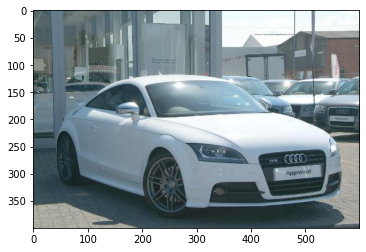

In [5]:
image = Image.open(TRAIN_PATH+'/'+ '00001.jpg').convert("RGB")
plt.imshow(image)

In [6]:
def make_df(mode):
    if mode == 'train':
        file = io.loadmat(PATH + '/cars_train_annos.mat') 
    elif mode =='test':
         file = io.loadmat(PATH + '/cars_test_annos.mat') 
    df = pd.DataFrame(columns=['name', 'cls'])
    for i in range(len(file['annotations'][0])):
        f = file['annotations'][0]
        annot = f[i][4]
        files = f[i][5]  
        row = {'name': files[0], 'cls': int(annot[0][0])-1}
#         print(annot[0][0])
        df = df.append(row, ignore_index=True)
    return df
train_df = make_df('train')
train_df.head()    

,name,cls
0,00001.jpg,13
1,00002.jpg,2
2,00003.jpg,90
3,00004.jpg,133
4,00005.jpg,105


In [7]:
files = io.loadmat(PATH + '/cars_train_annos.mat') 
len(files['annotations'][0])

8144

In [8]:
file = io.loadmat(PATH + '/cars_test_annos.mat') 
len(file['annotations'][0])

8041

In [9]:
class CarDataset(Dataset):
    def __init__(self, names, df, mode):
        super().__init__()
        self.names = names
        self.mode = mode
        self.df = df
        self.len_ = len(self.names)

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError
        
    def __len__(self):
        return self.len_
      
    def load_sample(self, file, mode):
        if mode == 'test':
            image = Image.open(TEST_PATH+'/'+ file).convert("RGB")
        else:
            image = Image.open(TRAIN_PATH+'/'+ file).convert("RGB")
        image.load()
        return image
    
    def __getitem__(self, index):
        row = self.df.loc[self.df['name'] == self.names[index]]
        clss = row['cls'].item()
        name = self.names[index]
        x = self.load_sample(name,self.mode)
        x = self._prepare_sample(x)
        x = np.array(x, dtype='float32')/ 255
        transforms = T.Compose([T.ToTensor(),
                         T.RandomHorizontalFlip(),
                         T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        x = transforms(x)
        return x, clss            
            
            
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE_1, RESCALE_SIZE_2))
        return image

In [10]:
train_files,val_files = train_test_split(train_df['name'], train_size=0.75)
val_dataset = CarDataset(list(val_files), train_df,  'val')
train_dataset = CarDataset(list(train_files),train_df, 'train')

In [11]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

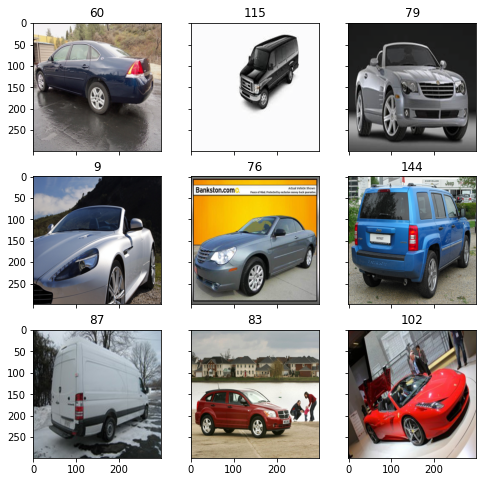

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_class = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_class]
    img_label = str(val_dataset[random_class][1])
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [13]:
nnum_classes = train_df['cls'].nunique()
nnum_classes

196

# Pytorch version

In [14]:
class GridReduction(nn.Module):
    def __init__(self, in_fts, out_fts):
        super(GridReduction, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts, kernel_size=(3, 3), stride=(2, 2))
        )

        self.branch2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        )

    def forward(self, input_img):
        o1 = self.branch1(input_img)
        o2 = self.branch2(input_img)
        x = torch.cat([o1, o2], dim=1)
        return x


class Inceptionx3(nn.Module):
    def __init__(self, in_fts, out_fts):
        super(Inceptionx3, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[0], kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=out_fts[0], out_channels=out_fts[0], kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Conv2d(in_channels=out_fts[0], out_channels=out_fts[0], kernel_size=(3, 3), stride=(1, 1), padding=1)
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[1], kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=out_fts[1], out_channels=out_fts[1], kernel_size=(3, 3), stride=(1, 1), padding=1),
        )
        self.branch3 = nn.Sequential(
            nn.AvgPool2d(kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[2], kernel_size=(1, 1), stride=(1, 1))
        )
        self.branch4 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[3], kernel_size=(1, 1), stride=(1, 1))
        )

    def forward(self, input_img):
        o1 = self.branch1(input_img)
        o2 = self.branch2(input_img)
        o3 = self.branch3(input_img)
        o4 = self.branch4(input_img)
        x = torch.cat([o1, o2, o3, o4], dim=1)
        return x


class Inceptionx5(nn.Module):
    def __init__(self, in_fts, out_fts, n=7):
        super(Inceptionx5, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[0], kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=out_fts[0], out_channels=out_fts[0], kernel_size=(1, n), stride=(1, 1),
                      padding=(0, n // 2)),
            nn.Conv2d(in_channels=out_fts[0], out_channels=out_fts[0], kernel_size=(n, 1), stride=(1, 1),
                      padding=(n // 2, 0)),
            nn.Conv2d(in_channels=out_fts[0], out_channels=out_fts[0], kernel_size=(1, n), stride=(1, 1),
                      padding=(0, n // 2)),
            nn.Conv2d(in_channels=out_fts[0], out_channels=out_fts[0], kernel_size=(n, 1), stride=(1, 1),
                      padding=(n // 2, 0)),
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[1], kernel_size=(1, 1), stride=(1, 1)),
            nn.Conv2d(in_channels=out_fts[1], out_channels=out_fts[1], kernel_size=(1, n), stride=(1, 1),
                      padding=(0, n // 2)),
            nn.Conv2d(in_channels=out_fts[1], out_channels=out_fts[1], kernel_size=(n, 1), stride=(1, 1),
                      padding=(n // 2, 0)),
        )
        self.branch3 = nn.Sequential(
            nn.AvgPool2d(kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[2], kernel_size=(1, 1), stride=(1, 1))
        )
        self.branch4 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[3], kernel_size=(1, 1), stride=(1, 1))
        )

    def forward(self, input_img):
        o1 = self.branch1(input_img)
        o2 = self.branch2(input_img)
        o3 = self.branch3(input_img)
        o4 = self.branch4(input_img)
        x = torch.cat([o1, o2, o3, o4], dim=1)
        return x


class Inceptionx2(nn.Module):
    def __init__(self, in_fts, out_fts):
        super(Inceptionx2, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[0] // 4, kernel_size=(1, 1)),
            nn.Conv2d(in_channels=out_fts[0] // 4, out_channels=out_fts[0] // 4, kernel_size=(3, 3), stride=(1, 1),
                      padding=1)
        )
        self.subbranch1_1 = nn.Sequential(
            nn.Conv2d(in_channels=out_fts[0] // 4, out_channels=out_fts[0], kernel_size=(1, 3), stride=(1, 1),
                      padding=(0, 3 // 2))
        )
        self.subbranch1_2 = nn.Sequential(
            nn.Conv2d(in_channels=out_fts[0] // 4, out_channels=out_fts[1], kernel_size=(3, 1), stride=(1, 1),
                      padding=(3 // 2, 0))
        )
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[2] // 4, kernel_size=(1, 1))
        )
        self.subbranch2_1 = nn.Sequential(
            nn.Conv2d(in_channels=out_fts[2] // 4, out_channels=out_fts[2], kernel_size=(1, 3), stride=(1, 1),
                      padding=(0, 3 // 2))
        )
        self.subbranch2_2 = nn.Sequential(
            nn.Conv2d(in_channels=out_fts[2] // 4, out_channels=out_fts[3], kernel_size=(3, 1), stride=(1, 1),
                      padding=(3 // 2, 0))
        )
        self.branch3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[4], kernel_size=(1, 1), stride=(1, 1))
        )
        self.branch4 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=out_fts[5], kernel_size=(1, 1), stride=(1, 1))
        )

    def forward(self, input_img):
        o1 = self.branch1(input_img)
        o11 = self.subbranch1_1(o1)
        o12 = self.subbranch1_2(o1)
        o2 = self.branch2(input_img)
        o21 = self.subbranch2_1(o2)
        o22 = self.subbranch2_2(o2)
        o3 = self.branch3(input_img)
        o4 = self.branch4(input_img)
        x = torch.cat([o11, o12, o21, o22, o3, o4], dim=1)
        return x


class AuxClassifier(nn.Module):
    def __init__(self, in_fts, num_classes):
        super(AuxClassifier, self).__init__()
        self.pool = nn.AdaptiveAvgPool2d(output_size=(5, 5))
        self.conv = nn.Conv2d(in_channels=in_fts, out_channels=128, kernel_size=(1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(5 * 5 * 128, 1024),
            nn.BatchNorm1d(num_features=1024),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        N = x.shape[0]
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(N, -1)
        x = self.classifier(x)
        return x


class Inception_v3(nn.Module):
    def __init__(self, in_fts=3, num_classes=nnum_classes):
        super(Inception_v3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_fts, out_channels=32, kernel_size=(3, 3), stride=(2, 2)),
            nn.BatchNorm2d(num_features=32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.BatchNorm2d(num_features=32)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),
            nn.BatchNorm2d(num_features=64)
        )
        self.pool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=80, kernel_size=(3, 3), stride=(1, 1))
        self.conv5 = nn.Conv2d(in_channels=80, out_channels=192, kernel_size=(3, 3), stride=(2, 2))
        self.conv6 = nn.Conv2d(in_channels=192, out_channels=288, kernel_size=(3, 3), stride=(1, 1), padding=1)

        list_incept = [Inceptionx3(in_fts=288, out_fts=[96, 96, 96, 96]),
                       Inceptionx3(in_fts=4 * 96, out_fts=[96, 96, 96, 96]),
                       Inceptionx3(in_fts=4 * 96, out_fts=[96, 96, 96, 96])]

        self.inceptx3 = nn.Sequential(*list_incept)
        self.grid_redn_1 = GridReduction(in_fts=4 * 96, out_fts=384)
        self.aux_classifier = AuxClassifier(768, num_classes)

        list_incept = [Inceptionx5(in_fts=768, out_fts=[160, 160, 160, 160]),
                       Inceptionx5(in_fts=4 * 160, out_fts=[160, 160, 160, 160]),
                       Inceptionx5(in_fts=4 * 160, out_fts=[160, 160, 160, 160]),
                       Inceptionx5(in_fts=4 * 160, out_fts=[160, 160, 160, 160]),
                       Inceptionx5(in_fts=4 * 160, out_fts=[160, 160, 160, 160])]

        self.inceptx5 = nn.Sequential(*list_incept)
        self.grid_redn_2 = GridReduction(in_fts=4 * 160, out_fts=640)

        list_incept = [Inceptionx2(in_fts=1280, out_fts=[256, 256, 192, 192, 64, 64]),
                       Inceptionx2(in_fts=1024, out_fts=[384, 384, 384, 384, 256, 256])]

        self.inceptx2 = nn.Sequential(*list_incept)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, input_img):
        N = input_img.shape[0]
        x = self.conv1(input_img)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.inceptx3(x)
        x = self.grid_redn_1(x)
        aux_out = self.aux_classifier(x)
        x = self.inceptx5(x)
        x = self.grid_redn_2(x)
        x = self.inceptx2(x)
        x = self.avgpool(x)
        x = x.reshape(N, -1)
        x = self.fc(x)
        if self.training:
            return [x, aux_out]
        else:
            return x

In [15]:
class AdaSmooth(Optimizer):
    def __init__(self, params, lr = 0.001, p1 = 0.5, p2 = 0.99, eps=1e-6, weight_decay=0, M = None ):
        self.steps = 0
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not p1 <= p2:
            raise ValueError("p2 must be > p1: p2 = {}, p1 = {}".format(p2, p1))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, 
                        p1=p1,
                        p2=p2, 
                        eps=eps, 
                        weight_decay=weight_decay,
                        M = M)
        super(AdaSmooth, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            norm_terms = []
            xt = []
            st = []
            nt = []
            lr, p1, p2, eps, weight_decay, M = (group['lr'],
                                            group['p1'],
                                            group['p2'],
                                            group['eps'],
                                            group['weight_decay'],
                                            group['M'])

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                if p.grad.is_sparse:
                    raise RuntimeError('Adasmooth does not support sparse gradients')
                grads.append(p.grad)

                state = self.state[p]

                # Lazy state initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['norm_terms'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['xt'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['st'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['nt'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                state['step'] += 1
                if state['step'] == M+1:
                    state['step'] = 0
                    state['st'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    state['nt'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                
                norm_terms.append(state['norm_terms'])
                xt.append(state['xt'])
                st.append(state['st'])
                nt.append(state['nt'])

            adasmooth(params_with_grad,
                     grads,
                     norm_terms,
                     xt,
                     st,
                     nt,
                     lr=lr,
                     p1=p1,
                     p2=p2,
                     eps=eps,
                     weight_decay=weight_decay)

        return loss


def adasmooth(params: List[Tensor],
             grads: List[Tensor],
             norm_terms: List[Tensor],
             xt: List[Tensor],
             st: List[Tensor],
             nt: List[Tensor],
             lr: float,
             p1: float,
             p2: float,
             eps: float,
             weight_decay: float):
    for (param, grad, norm_term, x, s, n) in zip(params, grads, norm_terms, xt, st, nt):
        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        if torch.is_complex(param):
            norm_term = torch.view_as_real(norm_term)
            grad = torch.view_as_real(grad)
        s =  torch.add(param - x, s)
        n = torch.add(torch.abs(param - x), n)
        er = torch.div(torch.abs(s), n)
        c = torch.add(torch.mul((p2 - p1), er), (1 - p2)) #8
        norm_term = torch.add(torch.mul(c ** 2, torch.mul(grad, grad)), torch.mul((1 - c ** 2), norm_term)) #9
        delta = torch.mul( 1/ torch.sqrt(torch.add(norm_term,eps)),grad) # 10
        if torch.is_complex(param):
            delta = torch.view_as_complex(delta)
        param.add_(delta, alpha=-lr) # update

In [16]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
    train_f1_score = []
    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs,aux_outputs = model(inputs)
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2
        loss.backward()
        optimizer.step()
#         print('step')
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
        train_f1_score.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro'))
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    train_f1 = np.average(train_f1_score)
    
    return train_loss, train_acc, train_f1

In [17]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0
    val_f1_score = []
    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs= model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        val_f1_score.append(f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro'))
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    val_f1 = np.average(val_f1_score)
    return val_loss, val_acc, val_f1

In [18]:
def train(train_files, val_files, model, epochs, batch_size, optim, model_name ='model'):
    train_loader = DataLoader(train_dataset, batch_size=batch_size,num_workers = 2, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,num_workers = 2, shuffle=False)
    max_val = 0
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} train_f1 {t_f1:0.4f} val_f1 {v_f1:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        if optim == 'ADAM':
            opt = torch.optim.Adam(model.parameters(), lr = 0.001)
        elif optim == 'ADASMOOTH':
            opt = AdaSmooth(model.parameters(), M = len(train_loader) )
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc,train_f1 = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss, val_acc,val_f1 = eval_epoch(model, val_loader, criterion) 
            history.append((train_loss, train_acc, val_loss, val_acc, train_f1, val_f1))
            if max_val<val_f1:
                max_val = val_f1
                torch.save(model, './'+model_name+'.dat')
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, t_f1 = train_f1, v_f1 =val_f1))
            
    return history

In [19]:
inception_ADAM =  Inception_v3()
inception_ADAM = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True) 
inception_ADAM = inception_ADAM.to(DEVICE)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

In [20]:
history1 = train(train_dataset, val_dataset, model=inception_ADAM, epochs=50, batch_size=60, optim = 'ADAM', model_name = 'inceptionv3_adam')

epoch:   2%|▏         | 1/50 [02:36<2:08:05, 156.85s/it]


Epoch 001 train_loss: 7.1452     val_loss 4.1372 train_acc 0.0345 val_acc 0.1007 train_f1 0.0175 val_f1 0.0564


epoch:   4%|▍         | 2/50 [04:55<1:56:54, 146.14s/it]


Epoch 002 train_loss: 4.3563     val_loss 2.9228 train_acc 0.2117 val_acc 0.2642 train_f1 0.1297 val_f1 0.1758


epoch:   6%|▌         | 3/50 [07:15<1:52:18, 143.36s/it]


Epoch 003 train_loss: 2.4805     val_loss 2.3667 train_acc 0.4722 val_acc 0.3826 train_f1 0.3293 val_f1 0.2636


epoch:   8%|▊         | 4/50 [09:35<1:48:44, 141.83s/it]


Epoch 004 train_loss: 1.5051     val_loss 1.6569 train_acc 0.6536 val_acc 0.5373 train_f1 0.5059 val_f1 0.3944


epoch:  10%|█         | 5/50 [11:56<1:46:19, 141.76s/it]


Epoch 005 train_loss: 0.9268     val_loss 1.7605 train_acc 0.7801 val_acc 0.5462 train_f1 0.6524 val_f1 0.4079


epoch:  12%|█▏        | 6/50 [14:14<1:43:04, 140.56s/it]


Epoch 006 train_loss: 0.6564     val_loss 1.2464 train_acc 0.8373 val_acc 0.6739 train_f1 0.7355 val_f1 0.5369


epoch:  14%|█▍        | 7/50 [16:33<1:40:21, 140.03s/it]


Epoch 007 train_loss: 0.4482     val_loss 1.2758 train_acc 0.8877 val_acc 0.6734 train_f1 0.8101 val_f1 0.5361


epoch:  16%|█▌        | 8/50 [18:54<1:38:08, 140.21s/it]


Epoch 008 train_loss: 0.3282     val_loss 1.0679 train_acc 0.9180 val_acc 0.7264 train_f1 0.8588 val_f1 0.5898


epoch:  18%|█▊        | 9/50 [21:12<1:35:18, 139.48s/it]


Epoch 009 train_loss: 0.3010     val_loss 1.2185 train_acc 0.9244 val_acc 0.6945 train_f1 0.8680 val_f1 0.5575


epoch:  20%|██        | 10/50 [23:31<1:32:57, 139.43s/it]


Epoch 010 train_loss: 0.2148     val_loss 1.2720 train_acc 0.9463 val_acc 0.6798 train_f1 0.9037 val_f1 0.5427


epoch:  22%|██▏       | 11/50 [25:49<1:30:24, 139.08s/it]


Epoch 011 train_loss: 0.1985     val_loss 1.1435 train_acc 0.9548 val_acc 0.7171 train_f1 0.9163 val_f1 0.5808


epoch:  24%|██▍       | 12/50 [28:09<1:28:08, 139.18s/it]


Epoch 012 train_loss: 0.1876     val_loss 1.1331 train_acc 0.9532 val_acc 0.7308 train_f1 0.9157 val_f1 0.6011


epoch:  26%|██▌       | 13/50 [30:31<1:26:25, 140.15s/it]


Epoch 013 train_loss: 0.1218     val_loss 1.0165 train_acc 0.9710 val_acc 0.7529 train_f1 0.9487 val_f1 0.6291


epoch:  28%|██▊       | 14/50 [32:51<1:24:00, 140.01s/it]


Epoch 014 train_loss: 0.1240     val_loss 1.1343 train_acc 0.9659 val_acc 0.7284 train_f1 0.9380 val_f1 0.5971


epoch:  30%|███       | 15/50 [35:12<1:21:48, 140.25s/it]


Epoch 015 train_loss: 0.1412     val_loss 1.1763 train_acc 0.9697 val_acc 0.7240 train_f1 0.9441 val_f1 0.5914


epoch:  32%|███▏      | 16/50 [37:35<1:19:59, 141.16s/it]


Epoch 016 train_loss: 0.1757     val_loss 1.3065 train_acc 0.9569 val_acc 0.7009 train_f1 0.9208 val_f1 0.5636


epoch:  34%|███▍      | 17/50 [39:54<1:17:17, 140.54s/it]


Epoch 017 train_loss: 0.2214     val_loss 1.5212 train_acc 0.9460 val_acc 0.6601 train_f1 0.9019 val_f1 0.5229


epoch:  36%|███▌      | 18/50 [42:14<1:14:52, 140.39s/it]


Epoch 018 train_loss: 0.2244     val_loss 1.2264 train_acc 0.9442 val_acc 0.7215 train_f1 0.9001 val_f1 0.5829


epoch:  38%|███▊      | 19/50 [44:35<1:12:39, 140.62s/it]


Epoch 019 train_loss: 0.1761     val_loss 1.2135 train_acc 0.9597 val_acc 0.7186 train_f1 0.9271 val_f1 0.5855


epoch:  40%|████      | 20/50 [46:57<1:10:24, 140.82s/it]


Epoch 020 train_loss: 0.1525     val_loss 1.2564 train_acc 0.9666 val_acc 0.7259 train_f1 0.9378 val_f1 0.5960


epoch:  42%|████▏     | 21/50 [49:19<1:08:14, 141.18s/it]


Epoch 021 train_loss: 0.1220     val_loss 1.0373 train_acc 0.9722 val_acc 0.7569 train_f1 0.9480 val_f1 0.6403


epoch:  44%|████▍     | 22/50 [51:39<1:05:50, 141.10s/it]


Epoch 022 train_loss: 0.0734     val_loss 0.9818 train_acc 0.9836 val_acc 0.7687 train_f1 0.9698 val_f1 0.6479


epoch:  46%|████▌     | 23/50 [54:01<1:03:37, 141.37s/it]


Epoch 023 train_loss: 0.0571     val_loss 1.0190 train_acc 0.9877 val_acc 0.7721 train_f1 0.9767 val_f1 0.6541


epoch:  48%|████▊     | 24/50 [56:21<1:01:03, 140.89s/it]


Epoch 024 train_loss: 0.0433     val_loss 0.9092 train_acc 0.9905 val_acc 0.7986 train_f1 0.9820 val_f1 0.6869


epoch:  50%|█████     | 25/50 [58:42<58:39, 140.77s/it]  


Epoch 025 train_loss: 0.0522     val_loss 1.0379 train_acc 0.9889 val_acc 0.7613 train_f1 0.9785 val_f1 0.6372


epoch:  52%|█████▏    | 26/50 [1:01:00<55:58, 139.95s/it]


Epoch 026 train_loss: 0.1055     val_loss 1.3266 train_acc 0.9758 val_acc 0.7053 train_f1 0.9556 val_f1 0.5701


epoch:  54%|█████▍    | 27/50 [1:03:19<53:34, 139.75s/it]


Epoch 027 train_loss: 0.2519     val_loss 1.8589 train_acc 0.9393 val_acc 0.6125 train_f1 0.8918 val_f1 0.4707


epoch:  56%|█████▌    | 28/50 [1:05:39<51:12, 139.67s/it]


Epoch 028 train_loss: 0.2517     val_loss 1.4135 train_acc 0.9460 val_acc 0.7122 train_f1 0.9026 val_f1 0.5772


epoch:  58%|█████▊    | 29/50 [1:07:56<48:39, 139.04s/it]


Epoch 029 train_loss: 0.1495     val_loss 1.1182 train_acc 0.9671 val_acc 0.7549 train_f1 0.9401 val_f1 0.6275


epoch:  60%|██████    | 30/50 [1:10:16<46:26, 139.33s/it]


Epoch 030 train_loss: 0.1184     val_loss 1.1842 train_acc 0.9730 val_acc 0.7500 train_f1 0.9522 val_f1 0.6235


epoch:  62%|██████▏   | 31/50 [1:12:35<44:06, 139.27s/it]


Epoch 031 train_loss: 0.0736     val_loss 0.9606 train_acc 0.9835 val_acc 0.7922 train_f1 0.9687 val_f1 0.6748


epoch:  64%|██████▍   | 32/50 [1:14:54<41:42, 139.04s/it]


Epoch 032 train_loss: 0.0590     val_loss 1.0399 train_acc 0.9872 val_acc 0.7775 train_f1 0.9762 val_f1 0.6613


epoch:  66%|██████▌   | 33/50 [1:17:15<39:33, 139.63s/it]


Epoch 033 train_loss: 0.0642     val_loss 1.1108 train_acc 0.9864 val_acc 0.7780 train_f1 0.9756 val_f1 0.6644


epoch:  68%|██████▊   | 34/50 [1:19:35<37:19, 139.96s/it]


Epoch 034 train_loss: 0.0506     val_loss 1.2464 train_acc 0.9858 val_acc 0.7441 train_f1 0.9743 val_f1 0.6178


epoch:  70%|███████   | 35/50 [1:21:53<34:46, 139.10s/it]


Epoch 035 train_loss: 0.0602     val_loss 1.2359 train_acc 0.9864 val_acc 0.7471 train_f1 0.9738 val_f1 0.6144


epoch:  72%|███████▏  | 36/50 [1:24:11<32:24, 138.92s/it]


Epoch 036 train_loss: 0.0933     val_loss 1.2413 train_acc 0.9763 val_acc 0.7446 train_f1 0.9565 val_f1 0.6166


epoch:  74%|███████▍  | 37/50 [1:26:30<30:05, 138.92s/it]


Epoch 037 train_loss: 0.0799     val_loss 1.3829 train_acc 0.9813 val_acc 0.7220 train_f1 0.9648 val_f1 0.5862


epoch:  76%|███████▌  | 38/50 [1:28:48<27:44, 138.73s/it]


Epoch 038 train_loss: 0.1077     val_loss 1.4956 train_acc 0.9738 val_acc 0.7028 train_f1 0.9529 val_f1 0.5721


epoch:  78%|███████▊  | 39/50 [1:31:07<25:25, 138.65s/it]


Epoch 039 train_loss: 0.1660     val_loss 1.3083 train_acc 0.9605 val_acc 0.7250 train_f1 0.9260 val_f1 0.5948


epoch:  80%|████████  | 40/50 [1:33:25<23:05, 138.56s/it]


Epoch 040 train_loss: 0.1235     val_loss 1.2206 train_acc 0.9725 val_acc 0.7466 train_f1 0.9493 val_f1 0.6194


epoch:  82%|████████▏ | 41/50 [1:35:44<20:46, 138.51s/it]


Epoch 041 train_loss: 0.0951     val_loss 1.1227 train_acc 0.9790 val_acc 0.7662 train_f1 0.9608 val_f1 0.6443


epoch:  84%|████████▍ | 42/50 [1:38:02<18:28, 138.56s/it]


Epoch 042 train_loss: 0.0663     val_loss 1.1103 train_acc 0.9874 val_acc 0.7746 train_f1 0.9770 val_f1 0.6565


epoch:  86%|████████▌ | 43/50 [1:40:21<16:09, 138.54s/it]


Epoch 043 train_loss: 0.0728     val_loss 1.3208 train_acc 0.9831 val_acc 0.7446 train_f1 0.9677 val_f1 0.6166


epoch:  88%|████████▊ | 44/50 [1:42:40<13:52, 138.73s/it]


Epoch 044 train_loss: 0.0751     val_loss 1.3136 train_acc 0.9841 val_acc 0.7495 train_f1 0.9693 val_f1 0.6225


epoch:  90%|█████████ | 45/50 [1:44:58<11:33, 138.67s/it]


Epoch 045 train_loss: 0.0505     val_loss 1.0284 train_acc 0.9890 val_acc 0.7937 train_f1 0.9797 val_f1 0.6857


epoch:  92%|█████████▏| 46/50 [1:47:16<09:14, 138.51s/it]


Epoch 046 train_loss: 0.0381     val_loss 1.2035 train_acc 0.9918 val_acc 0.7662 train_f1 0.9849 val_f1 0.6390


epoch:  94%|█████████▍| 47/50 [1:49:35<06:55, 138.38s/it]


Epoch 047 train_loss: 0.0580     val_loss 1.3286 train_acc 0.9858 val_acc 0.7367 train_f1 0.9741 val_f1 0.6069


epoch:  96%|█████████▌| 48/50 [1:51:52<04:36, 138.09s/it]


Epoch 048 train_loss: 0.1053     val_loss 1.4026 train_acc 0.9751 val_acc 0.7181 train_f1 0.9540 val_f1 0.5819


epoch:  98%|█████████▊| 49/50 [1:54:11<02:18, 138.24s/it]


Epoch 049 train_loss: 0.1320     val_loss 1.2661 train_acc 0.9692 val_acc 0.7412 train_f1 0.9455 val_f1 0.6090


epoch: 100%|██████████| 50/50 [1:56:31<00:00, 139.82s/it]


Epoch 050 train_loss: 0.1341     val_loss 1.3966 train_acc 0.9661 val_acc 0.7073 train_f1 0.9387 val_f1 0.5706


In [21]:
loss1, acc1, val_loss1, val_acc1, tr_f11, val_f11 = zip(*history1)

In [22]:
inception_ADASMOOTH =  Inception_v3()
inception_ADASMOOTH = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True) 
inception_ADASMOOTH = inception_ADASMOOTH.to(DEVICE)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [23]:
history2 = train(train_dataset, val_dataset, model=inception_ADASMOOTH, epochs=50, batch_size=60,optim = 'ADASMOOTH', model_name = 'inceptionv3_adam')

epoch:   2%|▏         | 1/50 [02:17<1:52:18, 137.52s/it]


Epoch 001 train_loss: 7.8104     val_loss 5.5515 train_acc 0.0544 val_acc 0.0742 train_f1 0.0300 val_f1 0.0423


epoch:   4%|▍         | 2/50 [04:35<1:50:11, 137.74s/it]


Epoch 002 train_loss: 5.2693     val_loss 5.5892 train_acc 0.2561 val_acc 0.0928 train_f1 0.1612 val_f1 0.0601


epoch:   6%|▌         | 3/50 [06:52<1:47:36, 137.38s/it]


Epoch 003 train_loss: 3.3663     val_loss 4.4788 train_acc 0.4843 val_acc 0.2633 train_f1 0.3404 val_f1 0.1805


epoch:   8%|▊         | 4/50 [09:09<1:45:08, 137.14s/it]


Epoch 004 train_loss: 2.1143     val_loss 2.5366 train_acc 0.6586 val_acc 0.5226 train_f1 0.5106 val_f1 0.3850


epoch:  10%|█         | 5/50 [11:26<1:43:02, 137.39s/it]


Epoch 005 train_loss: 1.4190     val_loss 2.4189 train_acc 0.7605 val_acc 0.5334 train_f1 0.6305 val_f1 0.3991


epoch:  12%|█▏        | 6/50 [13:44<1:40:48, 137.46s/it]


Epoch 006 train_loss: 0.9831     val_loss 2.3818 train_acc 0.8287 val_acc 0.5663 train_f1 0.7194 val_f1 0.4286


epoch:  14%|█▍        | 7/50 [16:05<1:39:17, 138.55s/it]


Epoch 007 train_loss: 0.7016     val_loss 1.8501 train_acc 0.8744 val_acc 0.6424 train_f1 0.7894 val_f1 0.5026


epoch:  16%|█▌        | 8/50 [18:23<1:36:50, 138.35s/it]


Epoch 008 train_loss: 0.4911     val_loss 2.0798 train_acc 0.9082 val_acc 0.6198 train_f1 0.8435 val_f1 0.4829


epoch:  18%|█▊        | 9/50 [20:40<1:34:20, 138.07s/it]


Epoch 009 train_loss: 0.3503     val_loss 1.6340 train_acc 0.9298 val_acc 0.6778 train_f1 0.8784 val_f1 0.5415


epoch:  20%|██        | 10/50 [22:58<1:31:59, 137.98s/it]


Epoch 010 train_loss: 0.2717     val_loss 2.0035 train_acc 0.9470 val_acc 0.6252 train_f1 0.9040 val_f1 0.4952


epoch:  22%|██▏       | 11/50 [25:16<1:29:42, 138.00s/it]


Epoch 011 train_loss: 0.2145     val_loss 1.7515 train_acc 0.9563 val_acc 0.6881 train_f1 0.9231 val_f1 0.5594


epoch:  24%|██▍       | 12/50 [27:38<1:28:06, 139.12s/it]


Epoch 012 train_loss: 0.2000     val_loss 1.5403 train_acc 0.9584 val_acc 0.7122 train_f1 0.9261 val_f1 0.5808


epoch:  26%|██▌       | 13/50 [29:58<1:25:58, 139.41s/it]


Epoch 013 train_loss: 0.1486     val_loss 1.7189 train_acc 0.9705 val_acc 0.6768 train_f1 0.9470 val_f1 0.5392


epoch:  28%|██▊       | 14/50 [32:16<1:23:28, 139.13s/it]


Epoch 014 train_loss: 0.1201     val_loss 1.3272 train_acc 0.9748 val_acc 0.7603 train_f1 0.9546 val_f1 0.6393


epoch:  30%|███       | 15/50 [34:35<1:21:06, 139.05s/it]


Epoch 015 train_loss: 0.1135     val_loss 1.1483 train_acc 0.9782 val_acc 0.7917 train_f1 0.9594 val_f1 0.6794


epoch:  32%|███▏      | 16/50 [36:54<1:18:49, 139.09s/it]


Epoch 016 train_loss: 0.0614     val_loss 1.1591 train_acc 0.9862 val_acc 0.7834 train_f1 0.9735 val_f1 0.6662


epoch:  34%|███▍      | 17/50 [39:15<1:16:40, 139.42s/it]


Epoch 017 train_loss: 0.0681     val_loss 1.1308 train_acc 0.9864 val_acc 0.7834 train_f1 0.9758 val_f1 0.6655


epoch:  36%|███▌      | 18/50 [41:35<1:14:36, 139.88s/it]


Epoch 018 train_loss: 0.0788     val_loss 1.0911 train_acc 0.9851 val_acc 0.7976 train_f1 0.9716 val_f1 0.6862


epoch:  38%|███▊      | 19/50 [43:55<1:12:14, 139.83s/it]


Epoch 019 train_loss: 0.0654     val_loss 1.2157 train_acc 0.9864 val_acc 0.7711 train_f1 0.9758 val_f1 0.6519


epoch:  40%|████      | 20/50 [46:15<1:09:50, 139.68s/it]


Epoch 020 train_loss: 0.0451     val_loss 1.6383 train_acc 0.9892 val_acc 0.7024 train_f1 0.9793 val_f1 0.5732


epoch:  42%|████▏     | 21/50 [48:35<1:07:37, 139.90s/it]


Epoch 021 train_loss: 0.0543     val_loss 1.4565 train_acc 0.9877 val_acc 0.7230 train_f1 0.9771 val_f1 0.5976


epoch:  44%|████▍     | 22/50 [50:56<1:05:24, 140.16s/it]


Epoch 022 train_loss: 0.0479     val_loss 0.9955 train_acc 0.9898 val_acc 0.8050 train_f1 0.9803 val_f1 0.6969


epoch:  46%|████▌     | 23/50 [53:15<1:02:55, 139.85s/it]


Epoch 023 train_loss: 0.0300     val_loss 0.8954 train_acc 0.9936 val_acc 0.8325 train_f1 0.9877 val_f1 0.7305


epoch:  48%|████▊     | 24/50 [55:33<1:00:24, 139.40s/it]


Epoch 024 train_loss: 0.0156     val_loss 1.0267 train_acc 0.9969 val_acc 0.8035 train_f1 0.9942 val_f1 0.6918


epoch:  50%|█████     | 25/50 [57:51<57:55, 139.02s/it]  


Epoch 025 train_loss: 0.0105     val_loss 0.9293 train_acc 0.9980 val_acc 0.8330 train_f1 0.9961 val_f1 0.7327


epoch:  52%|█████▏    | 26/50 [1:00:12<55:47, 139.47s/it]


Epoch 026 train_loss: 0.0109     val_loss 0.8635 train_acc 0.9979 val_acc 0.8369 train_f1 0.9955 val_f1 0.7442


epoch:  54%|█████▍    | 27/50 [1:02:32<53:30, 139.57s/it]


Epoch 027 train_loss: 0.0085     val_loss 0.8392 train_acc 0.9989 val_acc 0.8497 train_f1 0.9977 val_f1 0.7587


epoch:  56%|█████▌    | 28/50 [1:04:50<51:01, 139.15s/it]


Epoch 028 train_loss: 0.0057     val_loss 0.8487 train_acc 0.9987 val_acc 0.8477 train_f1 0.9971 val_f1 0.7557


epoch:  58%|█████▊    | 29/50 [1:07:08<48:35, 138.83s/it]


Epoch 029 train_loss: 0.0082     val_loss 0.8321 train_acc 0.9985 val_acc 0.8497 train_f1 0.9970 val_f1 0.7596


epoch:  60%|██████    | 30/50 [1:09:28<46:27, 139.36s/it]


Epoch 030 train_loss: 0.0060     val_loss 0.8630 train_acc 0.9987 val_acc 0.8458 train_f1 0.9976 val_f1 0.7483


epoch:  62%|██████▏   | 31/50 [1:11:50<44:17, 139.89s/it]


Epoch 031 train_loss: 0.0073     val_loss 0.8714 train_acc 0.9982 val_acc 0.8418 train_f1 0.9961 val_f1 0.7442


epoch:  64%|██████▍   | 32/50 [1:14:09<41:56, 139.79s/it]


Epoch 032 train_loss: 0.0071     val_loss 0.8520 train_acc 0.9984 val_acc 0.8468 train_f1 0.9970 val_f1 0.7546


epoch:  66%|██████▌   | 33/50 [1:16:29<39:34, 139.69s/it]


Epoch 033 train_loss: 0.0059     val_loss 0.8552 train_acc 0.9987 val_acc 0.8527 train_f1 0.9976 val_f1 0.7630


epoch:  68%|██████▊   | 34/50 [1:18:49<37:18, 139.89s/it]


Epoch 034 train_loss: 0.0073     val_loss 0.8681 train_acc 0.9985 val_acc 0.8463 train_f1 0.9977 val_f1 0.7517


epoch:  70%|███████   | 35/50 [1:21:11<35:05, 140.39s/it]


Epoch 035 train_loss: 0.0060     val_loss 0.8500 train_acc 0.9985 val_acc 0.8477 train_f1 0.9969 val_f1 0.7554


epoch:  72%|███████▏  | 36/50 [1:23:32<32:48, 140.59s/it]


Epoch 036 train_loss: 0.0067     val_loss 0.8408 train_acc 0.9987 val_acc 0.8566 train_f1 0.9975 val_f1 0.7642


epoch:  74%|███████▍  | 37/50 [1:25:53<30:31, 140.85s/it]


Epoch 037 train_loss: 0.0051     val_loss 0.8374 train_acc 0.9989 val_acc 0.8536 train_f1 0.9977 val_f1 0.7613


epoch:  76%|███████▌  | 38/50 [1:28:13<28:07, 140.60s/it]


Epoch 038 train_loss: 0.0054     val_loss 0.8385 train_acc 0.9989 val_acc 0.8522 train_f1 0.9975 val_f1 0.7606


epoch:  78%|███████▊  | 39/50 [1:30:34<25:47, 140.72s/it]


Epoch 039 train_loss: 0.0063     val_loss 0.8714 train_acc 0.9984 val_acc 0.8497 train_f1 0.9969 val_f1 0.7575


epoch:  80%|████████  | 40/50 [1:32:54<23:25, 140.56s/it]


Epoch 040 train_loss: 0.0050     val_loss 0.8579 train_acc 0.9985 val_acc 0.8477 train_f1 0.9973 val_f1 0.7557


epoch:  82%|████████▏ | 41/50 [1:35:15<21:06, 140.75s/it]


Epoch 041 train_loss: 0.0045     val_loss 0.8475 train_acc 0.9985 val_acc 0.8522 train_f1 0.9970 val_f1 0.7595


epoch:  84%|████████▍ | 42/50 [1:37:36<18:45, 140.72s/it]


Epoch 042 train_loss: 0.0047     val_loss 0.8369 train_acc 0.9987 val_acc 0.8531 train_f1 0.9976 val_f1 0.7602


epoch:  86%|████████▌ | 43/50 [1:39:59<16:29, 141.31s/it]


Epoch 043 train_loss: 0.0060     val_loss 0.8260 train_acc 0.9984 val_acc 0.8517 train_f1 0.9971 val_f1 0.7599


epoch:  88%|████████▊ | 44/50 [1:42:19<14:05, 140.97s/it]


Epoch 044 train_loss: 0.0057     val_loss 0.8499 train_acc 0.9984 val_acc 0.8527 train_f1 0.9970 val_f1 0.7594


epoch:  90%|█████████ | 45/50 [1:44:41<11:46, 141.22s/it]


Epoch 045 train_loss: 0.0042     val_loss 0.8436 train_acc 0.9990 val_acc 0.8576 train_f1 0.9981 val_f1 0.7677


epoch:  92%|█████████▏| 46/50 [1:47:02<09:24, 141.18s/it]


Epoch 046 train_loss: 0.0051     val_loss 0.8544 train_acc 0.9987 val_acc 0.8527 train_f1 0.9978 val_f1 0.7612


epoch:  94%|█████████▍| 47/50 [1:49:23<07:03, 141.14s/it]


Epoch 047 train_loss: 0.0051     val_loss 0.8806 train_acc 0.9984 val_acc 0.8482 train_f1 0.9969 val_f1 0.7539


epoch:  96%|█████████▌| 48/50 [1:51:45<04:42, 141.29s/it]


Epoch 048 train_loss: 0.0089     val_loss 0.9030 train_acc 0.9977 val_acc 0.8414 train_f1 0.9961 val_f1 0.7430


epoch:  98%|█████████▊| 49/50 [1:54:05<02:21, 141.03s/it]


Epoch 049 train_loss: 0.0058     val_loss 0.9004 train_acc 0.9984 val_acc 0.8418 train_f1 0.9968 val_f1 0.7467


epoch: 100%|██████████| 50/50 [1:56:26<00:00, 139.73s/it]


Epoch 050 train_loss: 0.0051     val_loss 0.8827 train_acc 0.9990 val_acc 0.8463 train_f1 0.9979 val_f1 0.7527


In [24]:
loss2, acc2, val_loss2, val_acc2, tr_f12, val_f12= zip(*history2)

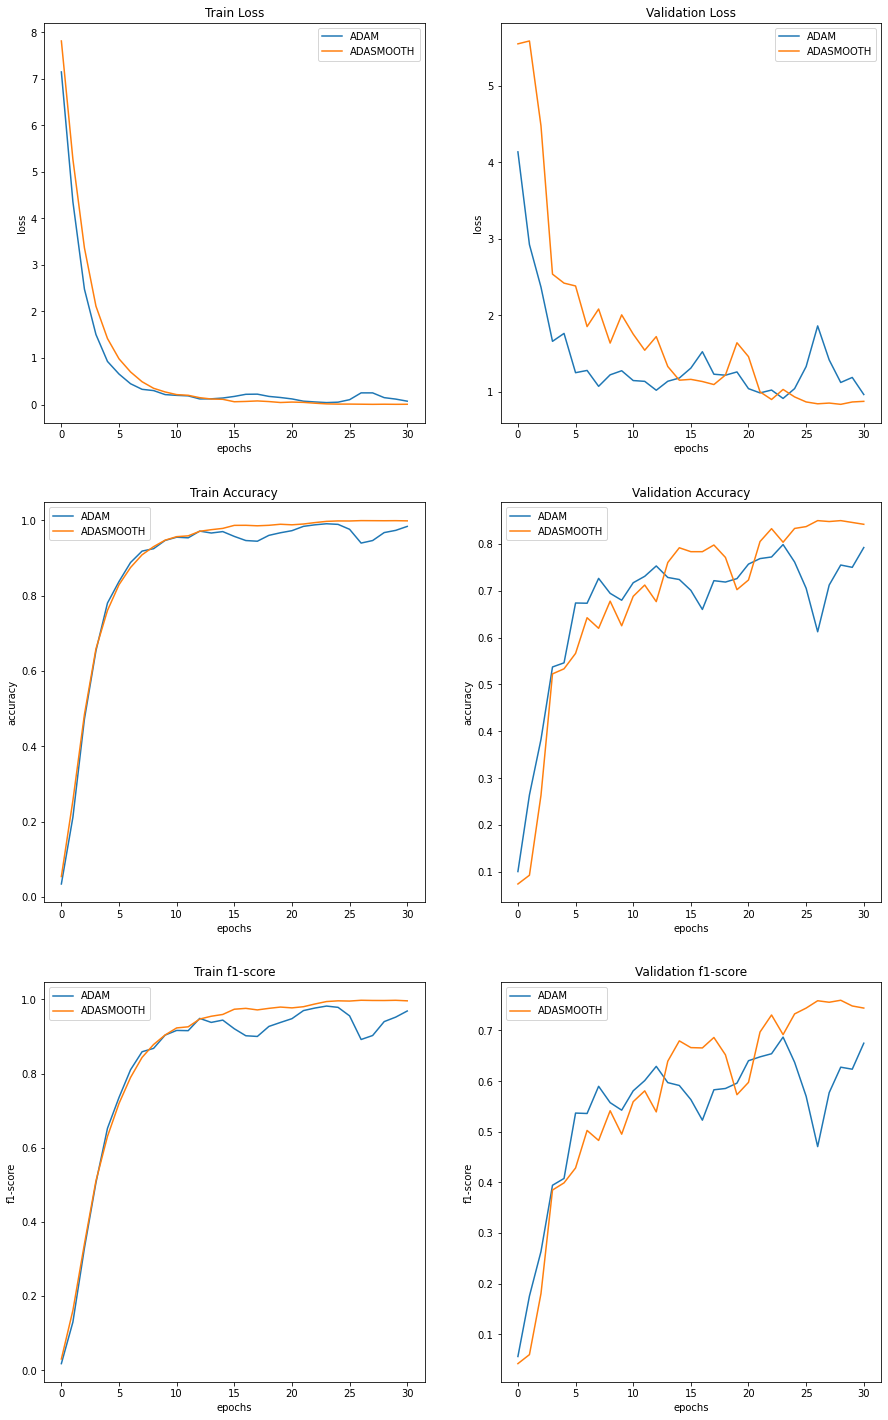

In [28]:
fig, axs = plt.subplots(3, 2, figsize=(15, 25))
axs[0, 0].plot(loss1[:31], label="ADAM")
axs[0, 0].plot(loss2[:31], label="ADASMOOTH")
axs[0, 0].set_title('Train Loss')
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")
axs[0, 0].legend()
axs[0, 1].plot(val_loss1[:31], label="ADAM")
axs[0, 1].plot(val_loss2[:31], label="ADASMOOTH")
axs[0, 1].set_title('Validation Loss')
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_ylabel("loss")
axs[0, 1].legend()
axs[1, 0].plot(acc1[:31], label="ADAM")
axs[1, 0].plot(acc2[:31], label="ADASMOOTH")
axs[1, 0].set_title('Train Accuracy')
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel('accuracy')
axs[1, 0].legend()
axs[1, 1].plot(val_acc1[:31], label="ADAM")
axs[1, 1].plot(val_acc2[:31], label="ADASMOOTH")
axs[1, 1].set_title('Validation Accuracy')
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_ylabel('accuracy')
axs[1, 1].legend()
axs[2, 0].plot(tr_f11[:31], label="ADAM")
axs[2, 0].plot(tr_f12[:31], label="ADASMOOTH")
axs[2, 0].set_title('Train f1-score')
axs[2, 0].set_xlabel("epochs")
axs[2, 0].set_ylabel('f1-score')
axs[2, 0].legend()
axs[2, 1].plot(val_f11[:31], label="ADAM")
axs[2, 1].plot(val_f12[:31], label="ADASMOOTH")
axs[2, 1].set_title('Validation f1-score')
axs[2, 1].set_xlabel("epochs")
axs[2, 1].set_ylabel('f1-score')
axs[2, 1].legend()
plt.savefig('gg.jpg')
plt.show()

In [ ]:
make_f1_score(inception_ADASMOOTH)